This notebook my implementation of **sharpness-aware minimization** in Pytorch with the CIFAR10/Fashion-MNIST dataset. Sharpness-aware minimization (SAM) was proposed in the paper - [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://openreview.net/pdf?id=6Tm1mposlrM)<sup>*</sup>.

Pedro Paulo Boechat Rabello Dutra Pinto

## Initial Setup

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 21 02:30:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow

Cloning into 'Sharpness-Aware-Minimization-TensorFlow'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 73 (delta 32), reused 23 (delta 4), pack-reused 0
Receiving objects: 100% (73/73), 157.40 KiB | 1.12 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
import sys
sys.path.append("Sharpness-Aware-Minimization-TensorFlow")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
#import resnet_cifar10
#import utils
#from .content.drive.MyDrive.Colab_Notebooks.AI.Project.utils import *
#from .content.drive.MyDrive.Colab_Notebooks.AI.Project.Import.utils import utils
#from tensorflow.keras import utils
#from .content.drive.MyDrive.Colab_Notebooks.AI.Project.Import import resnet_cifar10
import time

In [7]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.modules.batchnorm import _BatchNorm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
import random
import torch

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False


In [9]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


In [10]:
#Default values for the SAM optimizer
adaptive=True
batch_size=128
depth=16
dropout=0
epochs=30
label_smoothing=0.1
learning_rate=0.1
momentum=0.9
threads=2
rho=2
weight_decay=0.0005
width_factor=8
base_optimizer = torch.optim.SGD


# General Functions and DATASET Imports

In [97]:
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt

def PlotGraph(data,title,epochs,type):
  fig, ax = plt.subplots(figsize=(10,8))
  xdata =[i for i in range(len(data))]
  ydata = [data[row][type].item() for row in range(len(data))]

  #axes1 = fig.add_axes([0, 0, len(data), 1])
  ax.plot(xdata, ydata)
  ax.set_xlabel("epochs")
  ax.set_ylabel(type)
  #ax.set_ylim(0,1)
  ax.set_title(title)
  plt.show()

def PlotResults(data,title,epochs):
  fig, ax = plt.subplots(figsize=(16,12))
  rows = epochs
  cols = 3
  ax.set_ylim(-1, rows + 1)
  ax.set_xlim(0, cols + .5)
  for row in range(rows):
    #print("epoch[row] :"+str(epochs[row])+" with row = "+str(row))
    d = data[row]
    ax.text(x=.5, y=row, s=row+1, va='center', ha='left')
    ax.text(x=1.5, y=row, s=format(d["loss"].item(),".7f"), va='center', ha='left')
    ax.text(x=3, y=row, s=format(d["accuracy"].item(),".2f"), va='center', ha='right', weight='bold')
    #ax.text(x=3, y=row, s=d["prediction"].item(), va='center', ha='right')


  ax.text(.5, epochs - 0.25, 'Epoch', weight='bold', ha='left')
  ax.text(1.5, epochs - 0.25, 'Loss', weight='bold', ha='right')
  ax.text(3, epochs - 0.25, 'Accuracy', weight='bold', ha='right')

  for row in range(rows):
      ax.plot(
        [0, cols + 1],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
      )

  ax.plot([0, cols + 1], [epochs - 0.5, epochs - 0.5], lw='.5', c='black')

  rect = patches.Rectangle(
    (1.5, -.5),
    .65,
    epochs,
    ec='none',
    fc='grey',
    alpha=.2,
    zorder=-1
  )
  ax.add_patch(rect)

  ax.axis('off')

  ax.set_title(
    title,
    loc='left',
    fontsize=18,
    weight='bold'
  )

In [86]:
class LinearClassifier(nn.Module):
  def __init__(self):
    super(LinearClassifier, self).__init__()

    self.FirstLayer = nn.Linear(784,384)
    self.secondLayer =nn.Linear(384,182)
    self.ThirdLayer = nn.Linear(182, 10)

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.FirstLayer(x)
    x = F.relu(x)
    x = self.secondLayer(x)
    x = F.relu(x)
    x = self.ThirdLayer(x)
    return F.log_softmax(x,-1)

In [ ]:
class ConvolutionModel(nn.Module): # Any neural generated network should be generate

  def __init__(self):
    super(ConvolutionModel, self).__init__()

    self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
    self.conv2 = nn.Conv2d(3, 5, kernel_size=2)
    self.fc1 = nn.Linear(180, 100)
    self.fc2 = nn.Linear(100, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(F.max_pool2d(x,2))  # x now has shape (batchsize x 3 x 12 x 12)
    x = self.conv2(x)
    x = F.relu((F.max_pool2d(x,2)))
    #print(x.shape)
    x = x.view(-1, 180)
    x = F.relu(self.fc1(x))     # x has shape (batchsize x 10)
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return F.log_softmax(x,-1)

In [13]:
class Cifar:
    def __init__(self, batch_size, threads):
        mean, std = self._get_statistics()

        train_transform = transforms.Compose([
            torchvision.transforms.RandomCrop(size=(32, 32), padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

        self.train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=threads)
        self.test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=threads)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def _get_statistics(self):
        train_set = torchvision.datasets.CIFAR10(root='./cifar', train=True, download=True, transform=transforms.ToTensor())

        data = torch.cat([d[0] for d in DataLoader(train_set)])
        return data.mean(dim=[0, 2, 3]), data.std(dim=[0, 2, 3])

In [14]:
class fashionMNIST:
    def __init__(self, batch_size, threads):
        mean, std = self._get_statistics()

        train_transform = transforms.Compose([
            torchvision.transforms.RandomCrop(size=(28, 28), padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,),),
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,),)
        ])

        train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
        test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

        self.train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=threads)
        self.test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=threads)

        self.classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

    def _get_statistics(self):
        train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

        data = torch.cat([d[0] for d in DataLoader(train_set)])
        return data.mean(dim=[0, 2, 3]), data.std(dim=[0, 2, 3])

# Encapsulate SAM Logic

SAM is implemented as follows -

<center>
<img src="https://i.ibb.co/qRSfNX7/image.png"></img><br>
<small>Source: Original Paper</small>
</center>

In [100]:
class SAM(torch.optim.Optimizer):
  def __init__(self,params,neighborhood_size=2, rho=rho, adaptive=adaptive, **kwargs):
    defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
    super(SAM,self).__init__(params, defaults=defaults)
    self.sgd = torch.optim.SGD(self.param_groups, **kwargs)
    self.param_groups = self.sgd.param_groups
    self.p = neighborhood_size

  @torch.no_grad()
  def initial_step(self):
    #Compute "ew" whihc is given by the solution to a classical dual norm problem
    #Takes all the gradients that are none zero to calcuate the norm
    firstNorm = torch.norm(torch.stack([ ( torch.abs(p) * p.grad).norm(2).to(device) for group in self.param_groups for p in group["params"] if p.grad is not None ]),2)
    for group in self.param_groups:
      for p in group['params'] :
        if p.grad is not None :
          self.state[p]["old_parameter"] = p.data.clone()
          ew = self.p * torch.pow(p, 2) * p.grad * (group["rho"] / firstNorm + 1e-12).to(p)
          p.add_(ew)
    self.zero_grad()

  @torch.no_grad()
  def last_step(self):
    for group in self.param_groups:
      for p in group["params"]:
        if p.grad is not None:
          p.data = self.state[p]["old_parameter"]
    self.sgd.step()
    self.zero_grad()





In [16]:
#Loss function
def smooth_crossentropy(pred, gold, smoothing=0.1):
    n_class = pred.size(1)

    one_hot = torch.full_like(pred, fill_value=smoothing / (n_class - 1))
    one_hot.scatter_(dim=1, index=gold.unsqueeze(1), value=1.0 - smoothing)
    log_prob = F.log_softmax(pred, dim=1)

    return F.kl_div(input=log_prob, target=one_hot, reduction='none').sum(-1)

In [65]:
#Functions to change momentum according to the direction of the step of the
# SAM optimizer.
def disable_momentum(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_momentum(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

# Training functions SAM and regular optimizers

In [84]:
def trainSAM(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:

    model.train()
    train_loss = []
    train_counter = []
    for batch_idx, (images, targets) in enumerate(train_loader):
      #Save to device
      images = images.to(device)
      targets = targets.to(device)

      #images.view(-1,3,28,28)

      enable_momentum(model)
      output = model(images)
      #print("Output "+str(output.shape))
      #print("Targets "+str(targets.shape))
      loss = smooth_crossentropy(output, targets, smoothing=label_smoothing)
      loss.mean().backward()
      #First step
      optimizer.initial_step()

      # second forward-backward step
      disable_momentum(model)
      smooth_crossentropy(model(images), targets, smoothing=label_smoothing).mean().backward()
      optimizer.last_step()

      #print(type(loss))
      #print(loss)
      #print(type(loss.item()))
      #print(loss.item())
      #torch.mean(torch.stack(my_list), dim=0)
      train_loss.append(torch.mean(loss, dim=0)) # item() is to get the value of the tensor directly
      train_counter.append( (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # if batch_idx % 10 == 0: # We record our output every 10 batches
      #   train_loss.append(loss.item()) # item() is to get the value of the tensor directly
      #   train_counter.append( (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      if batch_idx % 100 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {torch.mean(loss, dim=0)}')
    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def testSAM(model: nn.Module,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    model.eval() # we need to set the mode for our model
    test_stat = {"loss":0,"accuracy":0,"prediction":0}
    prediction = torch.zeros(0,dtype=torch.long)
    test_counter = []
    #predList = []

    test_loss = 0
    correct = 0
    with torch.no_grad():
     for images, targets in test_loader:
       #Make sure the process happens in the GPU
       images = images.to(device)
       targets = targets.to(device)
       output = model(images)
       loss =smooth_crossentropy(output, targets,smoothing=label_smoothing)
       test_loss += torch.mean(loss, dim=0)
       pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
       prediction = torch.cat((prediction,pred.to("cpu")),dim=0)
       correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
    test_stat["loss"] = test_loss / len(test_loader.dataset)
    test_stat["accuracy"]= correct / len(test_loader.dataset)
    test_stat["prediction"]= prediction
    test_counter.append(len(test_loader.dataset)*epoch)

    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')
    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    print()
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


In [91]:
def train(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    # batch_idx, (images, targets) = next(enumerate(train_loader))
    # for i in range(epoch):

    # print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
    model.train() # we need to set the mode for our model
    train_loss = []
    train_counter = []
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      """print(images.size())
      print(type(images))
      images.view(-1,3,7,7)
      print(images.size())
      print(type(images))"""
      output = model(images)
      loss = smooth_crossentropy(output, targets,smoothing=label_smoothing) # Here is a typical loss function (negative log likelihood)
      loss.mean().backward()
      optimizer.step()

      train_loss.append(torch.mean(loss, dim=0)) # item() is to get the value of the tensor directly
      train_counter.append( (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # if batch_idx % 10 == 0: # We record our output every 10 batches
      #   train_loss.append(loss.item()) # item() is to get the value of the tensor directly
      #   train_counter.append( (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      if batch_idx % 100 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {torch.mean(loss, dim=0)}')
    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    model.eval() # we need to set the mode for our model
    test_stat = {"loss":0,"accuracy":0,"prediction":0}
    prediction = torch.zeros(0,dtype=torch.long)
    test_counter = []
    #predList = []

    test_loss = 0
    correct = 0
    with torch.no_grad():
     for images, targets in test_loader:
       #Make sure the process happens in the GPU
       images = images.to(device)
       targets = targets.to(device)
       output = model(images)
       loss =smooth_crossentropy(output, targets,smoothing=label_smoothing)
       test_loss += torch.mean(loss, dim=0)
       pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
       prediction = torch.cat((prediction,pred.to("cpu")),dim=0)
       correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples

    test_stat["loss"] = test_loss / len(test_loader.dataset)
    test_stat["accuracy"]= correct / len(test_loader.dataset)
    test_stat["prediction"]= prediction
    test_counter.append(len(test_loader.dataset)*epoch)

    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')
    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    print()
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat

# Training CIFAR-10 with SAM REAL

In [18]:
dataset = Cifar(128, 2)
print(len(dataset.train))
print(len(dataset.test))
print(dataset.classes)

100%|██████████| 170498071/170498071 [00:10<00:00, 15733881.13it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


100%|██████████| 170498071/170498071 [00:10<00:00, 15526189.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
391
79
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [85]:
start = time.time()
max_epoch = 50
#classifier =  OurFC()
#classifier = classifier.to(device)
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=False)
model.to(device)
#optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)
optimizer = SAM(model.parameters(), rho=rho, adaptive=adaptive, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
train_result = []
test_NEWSAM = []
for epoch in range(1, max_epoch+1):
  train_result.append(trainSAM(model, optimizer,dataset.train,epoch))
  test_NEWSAM.append(testSAM(model,dataset.test,epoch))
end = time.time()
print(f'Finished Training after {end-start} s ')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: [0/50000] Loss: 6.167168140411377
Epoch 1: [12800/50000] Loss: 2.2240962982177734
Epoch 1: [25600/50000] Loss: 2.1756138801574707
Epoch 1: [38400/50000] Loss: 2.121817111968994
Test result on epoch 1: Avg loss is 174.35626220703125, Accuracy: 16.020000457763672%

Epoch 2: [0/50000] Loss: 2.1980557441711426
Epoch 2: [12800/50000] Loss: 2.1802217960357666
Epoch 2: [25600/50000] Loss: 2.1397104263305664
Epoch 2: [38400/50000] Loss: 2.2390007972717285
Test result on epoch 2: Avg loss is 171.66490173339844, Accuracy: 15.979999542236328%

Epoch 3: [0/50000] Loss: 2.118427276611328
Epoch 3: [12800/50000] Loss: 2.2058186531066895
Epoch 3: [25600/50000] Loss: 2.074247121810913
Epoch 3: [38400/50000] Loss: 2.025118827819824
Test result on epoch 3: Avg loss is 175.9154510498047, Accuracy: 17.8799991607666%

Epoch 4: [0/50000] Loss: 2.086402654647827
Epoch 4: [12800/50000] Loss: 2.0104150772094727
Epoch 4: [25600/50000] Loss: 2.116633176803589
Epoch 4: [38400/50000] Loss: 2.08071017265319

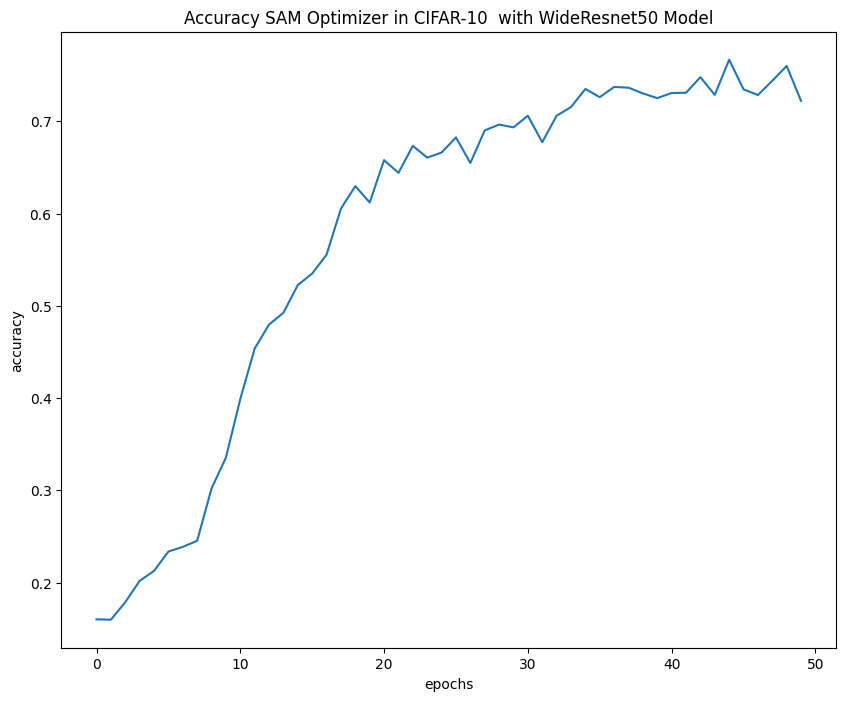

In [99]:
data = test_NEWSAM
title = 'Accuracy SAM Optimizer in CIFAR-10  with WideResnet50 Model'
epochs=50
PlotGraph(data,title,epochs,"accuracy")

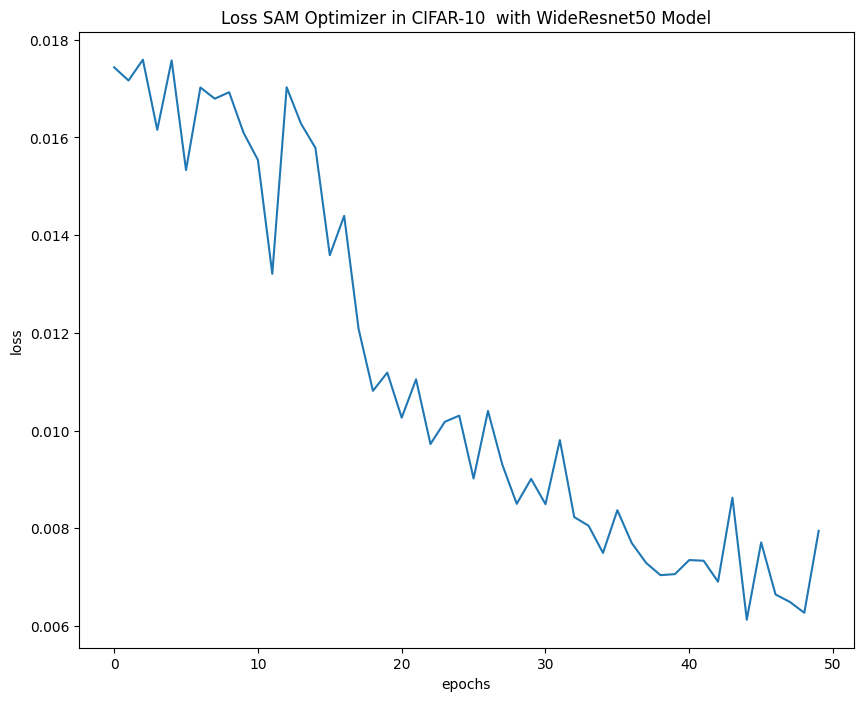

In [98]:
data = test_NEWSAM
title = 'Loss SAM Optimizer in CIFAR-10  with WideResnet50 Model'
epochs=50
PlotGraph(data,title,epochs,"loss")

# Training CIFAR-10 with SGD

In [92]:
start = time.time()
#Double of epochs because SAM runs twice as long
max_epoch = 100

model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=False)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
train_result = []
test_SGD = []
for epoch in range(1, max_epoch+1):
  train_result.append(train(model, optimizer,dataset.train,epoch))
  test_SGD.append(test(model,dataset.test,epoch))
end = time.time()
print(f'Finished Training after {end-start} s ')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1: [0/50000] Loss: 6.193399429321289
Epoch 1: [12800/50000] Loss: 1.7902438640594482
Epoch 1: [25600/50000] Loss: 1.8860853910446167
Epoch 1: [38400/50000] Loss: 1.7710366249084473
Test result on epoch 1: Avg loss is 129.93885803222656, Accuracy: 40.20000076293945%

Epoch 2: [0/50000] Loss: 1.5738704204559326
Epoch 2: [12800/50000] Loss: 1.6585136651992798
Epoch 2: [25600/50000] Loss: 1.5559055805206299
Epoch 2: [38400/50000] Loss: 1.4332966804504395
Test result on epoch 2: Avg loss is 105.56014251708984, Accuracy: 46.34000015258789%

Epoch 3: [0/50000] Loss: 1.3360430002212524
Epoch 3: [12800/50000] Loss: 1.4401178359985352
Epoch 3: [25600/50000] Loss: 1.3074227571487427
Epoch 3: [38400/50000] Loss: 1.4664127826690674
Test result on epoch 3: Avg loss is 122.06707000732422, Accuracy: 47.529998779296875%

Epoch 4: [0/50000] Loss: 1.3866910934448242
Epoch 4: [12800/50000] Loss: 1.292802095413208
Epoch 4: [25600/50000] Loss: 1.1908304691314697
Epoch 4: [38400/50000] Loss: 1.32081222

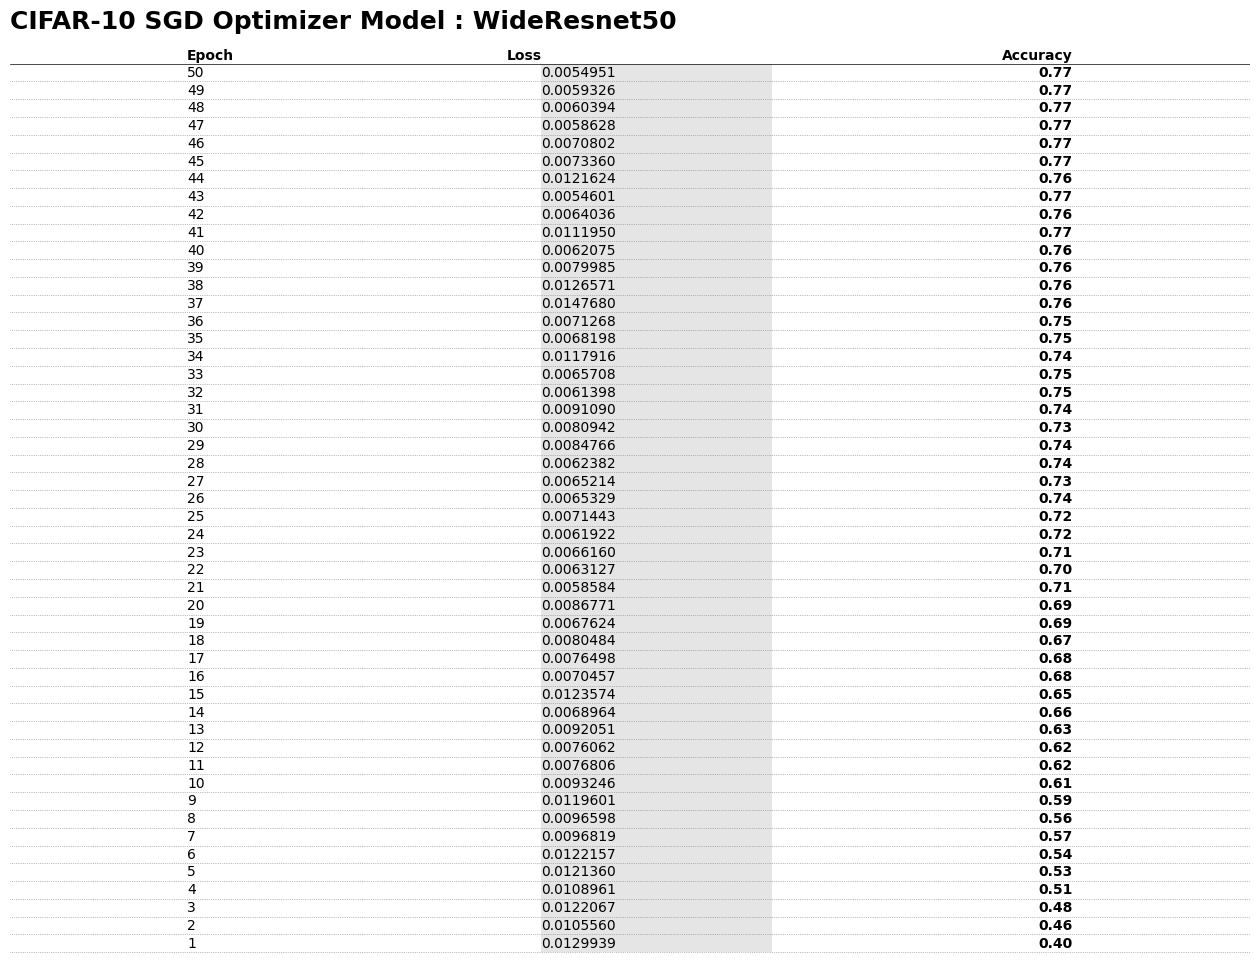

In [93]:
data = test_SGD
title = 'CIFAR-10 SGD Optimizer Model : WideResnet50 '
epochs = 50
PlotResults(data,title,epochs)

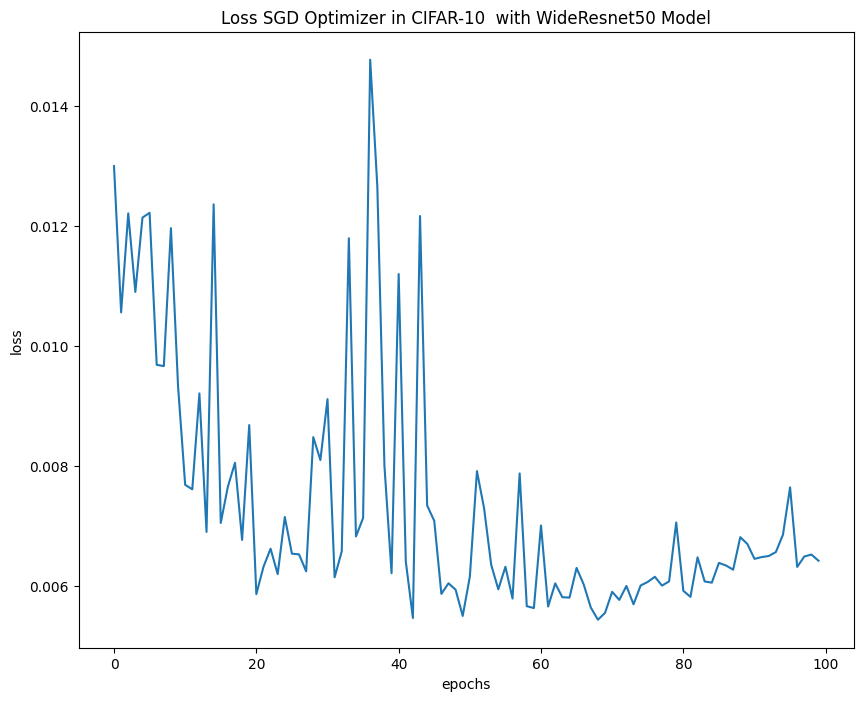

In [96]:
data = test_SGD
title = 'Loss SGD Optimizer in CIFAR-10  with WideResnet50 Model'
epochs=100
PlotGraph(data,title,epochs,"loss")

# Training Fashion-MNIST with SAM

In [ ]:
dataset = fashionMNIST(128, 2)
print(dataset.train)
print(dataset.test)
print(dataset.classes)

100%|██████████| 26421880/26421880 [00:02<00:00, 13147648.41it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209245.52it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3895571.97it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6547082.17it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('data', train=False, download=True, transform=transform)
batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [ ]:
start = time.time()
max_epoch = 50

#criterion = nn.CrossEntropyLoss()
#model = LinearClassifier()
modelConvSAMFashion = LinearClassifier()
modelConvSAMFashion.to(device)
optimizerConvSAMFashion = SAM(modelConvSAMFashion.parameters(), base_optimizer, rho=rho, adaptive=adaptive, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
train_result = []
test_SAM_Fashion = []
for epoch in range(1, max_epoch+1):
  train_result.append(trainSAM(modelConvSAMFashion, optimizerConvSAMFashion,train_loader,epoch))
  test_SAM_Fashion.append(testSAM(modelConvSAMFashion,test_loader,epoch))
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 1.7653985023498535
Epoch 1: [6400/60000] Loss: 0.7722858190536499
Epoch 1: [12800/60000] Loss: 0.6032145023345947
Epoch 1: [19200/60000] Loss: 0.5150987505912781
Epoch 1: [25600/60000] Loss: 0.7380678653717041
Epoch 1: [32000/60000] Loss: 0.26548677682876587
Epoch 1: [38400/60000] Loss: 0.6883009672164917
Epoch 1: [44800/60000] Loss: 0.5992132425308228
Epoch 1: [51200/60000] Loss: 0.6309970617294312
Epoch 1: [57600/60000] Loss: 0.5450811386108398
Test result on epoch 1: Avg loss is 5.592807769775391, Accuracy: 73.75%

Epoch 2: [0/60000] Loss: 0.4425339102745056
Epoch 2: [6400/60000] Loss: 0.42123568058013916
Epoch 2: [12800/60000] Loss: 0.7130868434906006
Epoch 2: [19200/60000] Loss: 0.5216810703277588
Epoch 2: [25600/60000] Loss: 0.32497817277908325
Epoch 2: [32000/60000] Loss: 0.6414863467216492
Epoch 2: [38400/60000] Loss: 0.5309544801712036
Epoch 2: [44800/60000] Loss: 0.7208279371261597
Epoch 2: [51200/60000] Loss: 0.4443482458591461
Epoch 2: [57600/60000]

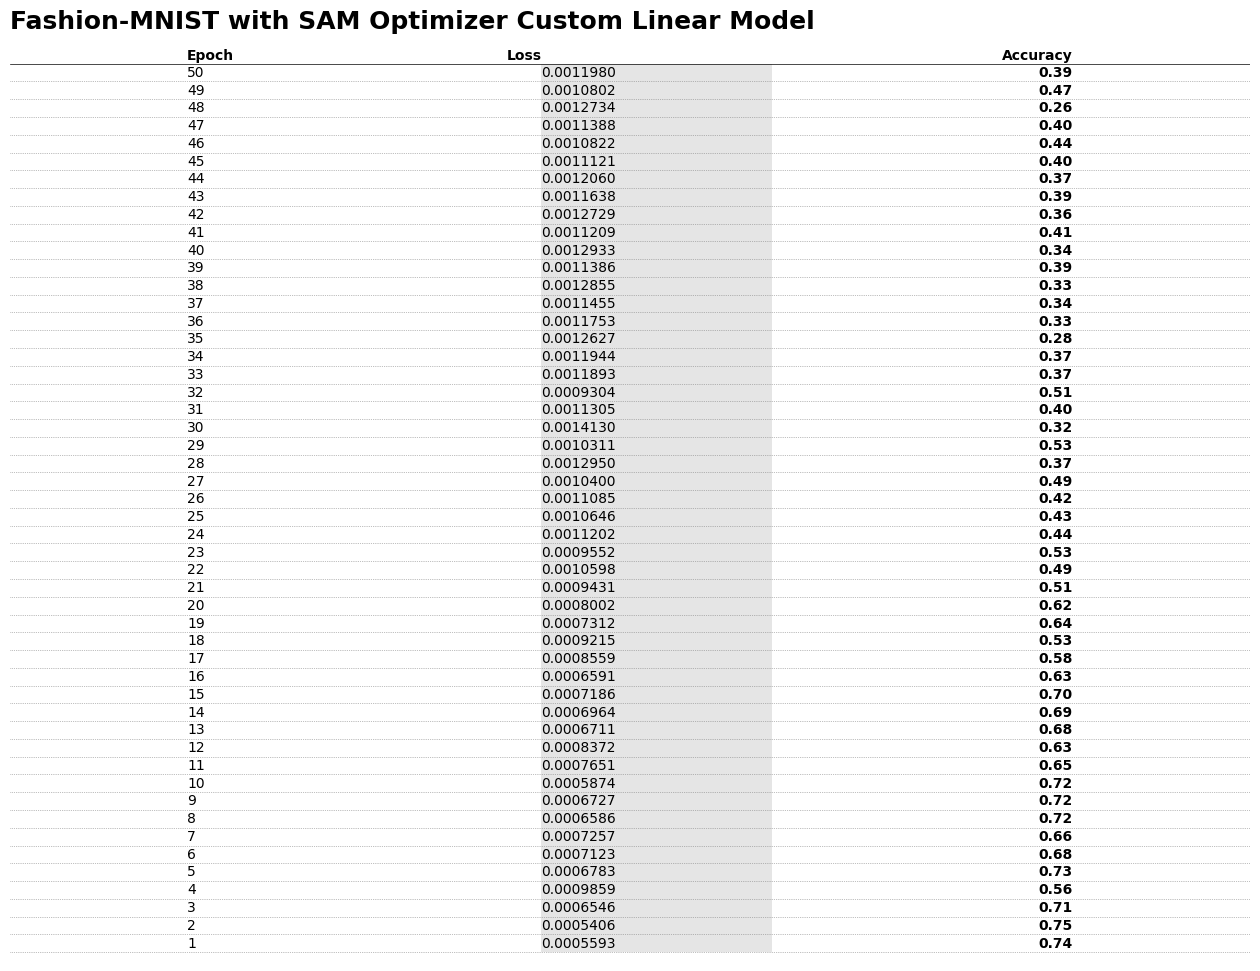

In [ ]:
data = test_SAM_Fashion
title = 'Fashion-MNIST with SAM Optimizer Custom Linear Model'
epochs=50
PlotResults(data,title,epochs)

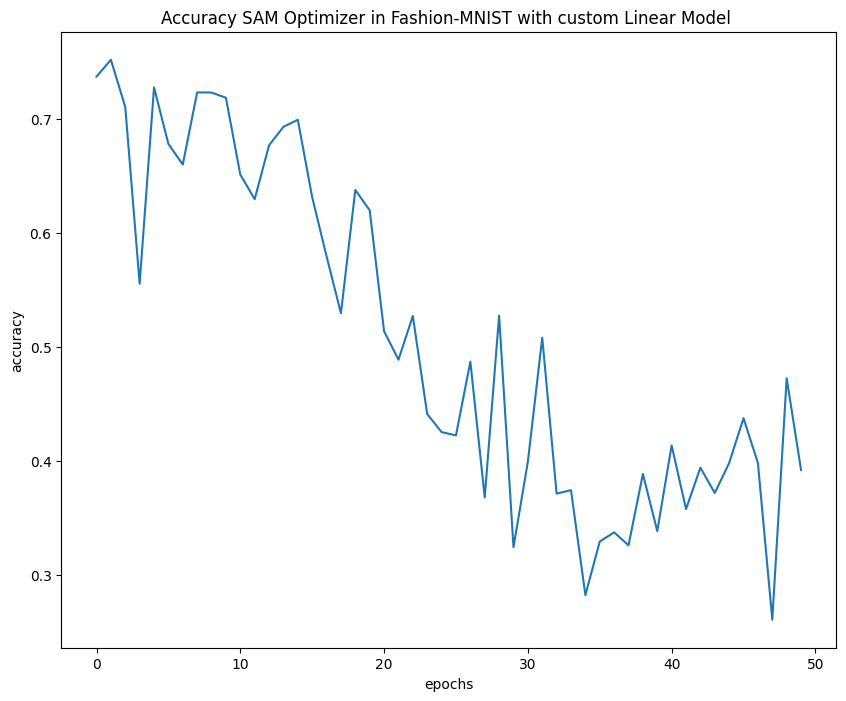

In [ ]:
data = test_SAM_Fashion
title = 'Accuracy SAM Optimizer in Fashion-MNIST with custom Linear Model '
epochs=50
PlotGraph(data,title,epochs,"accuracy")

# Training Fashion-MNIST with SGD

In [ ]:
start = time.time()
#Double of epochs because SAM runs twice as long
max_epoch = 100

#model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model = LinearClassifier()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
train_result = []
test_SGD_Fashion = []
for epoch in range(1, max_epoch+1):
  train_result.append(train(model, optimizer,dataset.train,epoch))
  test_SGD_Fashion.append(test(model,dataset.test,epoch))
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 1.760274052619934
Epoch 1: [12800/60000] Loss: 1.0137572288513184
Epoch 1: [25600/60000] Loss: 0.9378056526184082
Epoch 1: [38400/60000] Loss: 0.839085578918457
Epoch 1: [51200/60000] Loss: 0.7616366147994995
Test result on epoch 1: Avg loss is 51.707149505615234, Accuracy: 69.79000091552734%

Epoch 2: [0/60000] Loss: 0.7091752290725708
Epoch 2: [12800/60000] Loss: 0.6955309510231018
Epoch 2: [25600/60000] Loss: 0.7292769551277161
Epoch 2: [38400/60000] Loss: 0.7191973924636841
Epoch 2: [51200/60000] Loss: 0.7178289294242859
Test result on epoch 2: Avg loss is 46.67185974121094, Accuracy: 73.1199951171875%

Epoch 3: [0/60000] Loss: 0.5694234371185303
Epoch 3: [12800/60000] Loss: 0.6296828389167786
Epoch 3: [25600/60000] Loss: 0.6590975522994995
Epoch 3: [38400/60000] Loss: 0.6104627847671509
Epoch 3: [51200/60000] Loss: 0.5648171901702881
Test result on epoch 3: Avg loss is 43.474334716796875, Accuracy: 74.3699951171875%

Epoch 4: [0/60000] Loss: 0.558143973350

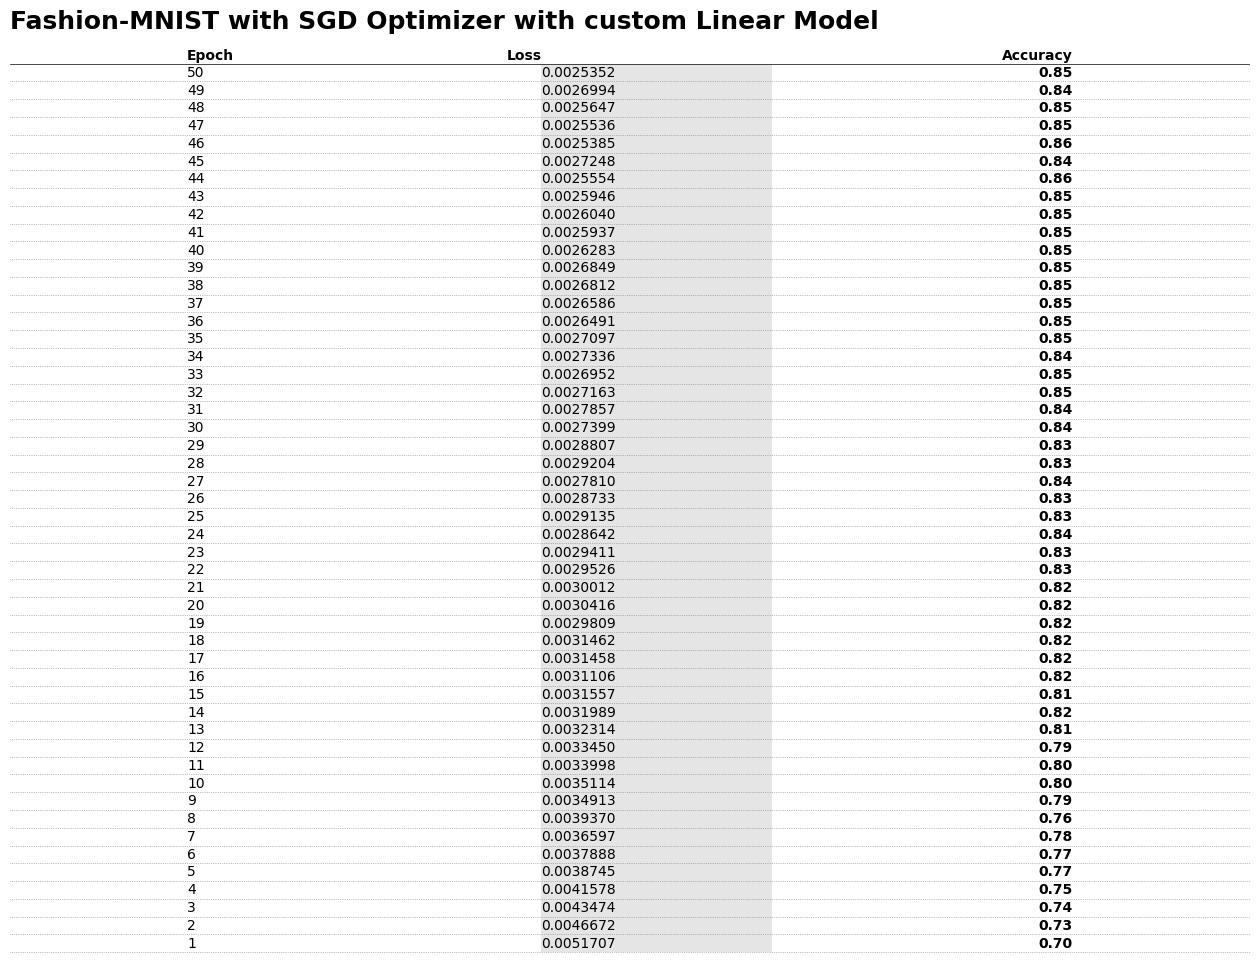

In [ ]:
data = test_SGD_Fashion
title = 'Fashion-MNIST with SGD Optimizer with custom Linear Model'
epochs =50
PlotResults(data,title,epochs)

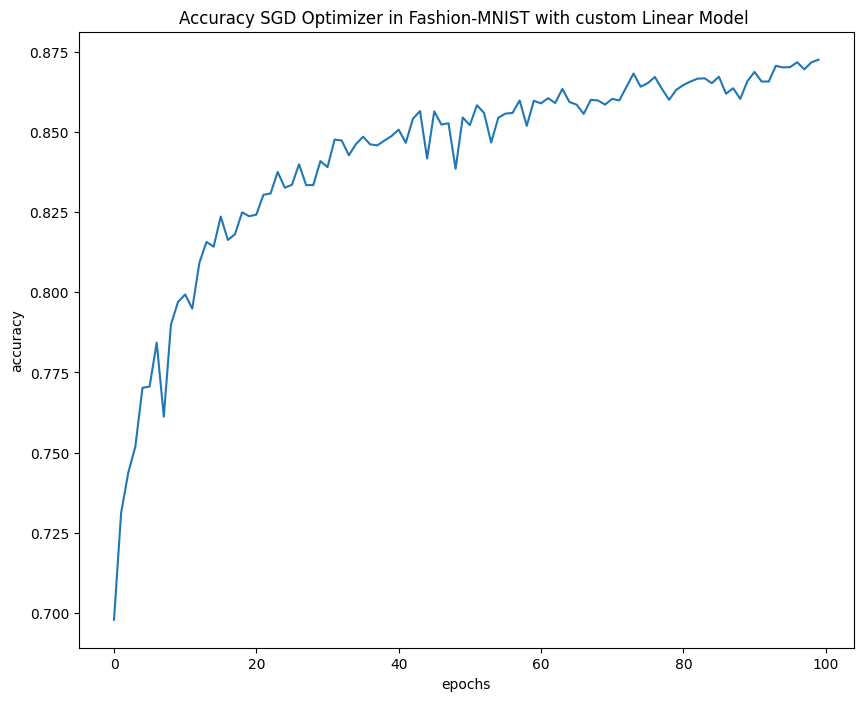

In [ ]:
data = test_SGD_Fashion
title = 'Accuracy SGD Optimizer in Fashion-MNIST with custom Linear Model '
epochs=100
PlotGraph(data,title,epochs,"accuracy")